# 2. Skill Demand

### Importar módulos y librerías

In [2]:
import ast 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cargar datos

In [3]:
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

### Limpieza de datos

In [4]:
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

### Filtrar para puestos en Argentina

In [5]:
df_ARG = df[df['job_country'] == 'Argentina']

### .explode

The .explode() method is designed to expand entries in a list-like column across multiple rows, making each element in the list a separate row.

In [7]:
df_skills = df_ARG.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
236,Científico de Datos LLM,None
417,Data Science SR Puerto Madero,java
417,Data Science SR Puerto Madero,scala
863,Data Engineer Jr,python
863,Data Engineer Jr,azure
...,...,...
785668,Jr Data Analyst,excel
785668,Jr Data Analyst,tableau
785668,Jr Data Analyst,power bi
785668,Jr Data Analyst,spss


### Contar skills por puesto de trabajo

Groups DataFrame by job_skills and job_title_short, counting the occurrences of each skill within each job title

Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. 

The final DataFrame, df_skills_count, shows the frequency of each skill with each job title.

In [8]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1054,sql,Data Engineer,1424
822,python,Data Engineer,1401
823,python,Data Scientist,1048
1055,sql,Data Scientist,930
71,aws,Data Engineer,803
...,...,...,...
11,airtable,Machine Learning Engineer,1
1245,word,Cloud Engineer,1
10,airtable,Data Analyst,1
1264,zoom,Senior Data Engineer,1


### Crear lista de top 3 puestos de trabajo

In [9]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

### Barplot para visualizar las skills según cantidad de apariciones

Para las top 5 skills para los top 3 puestos de trabajo (que obtuvimos anteriormente)

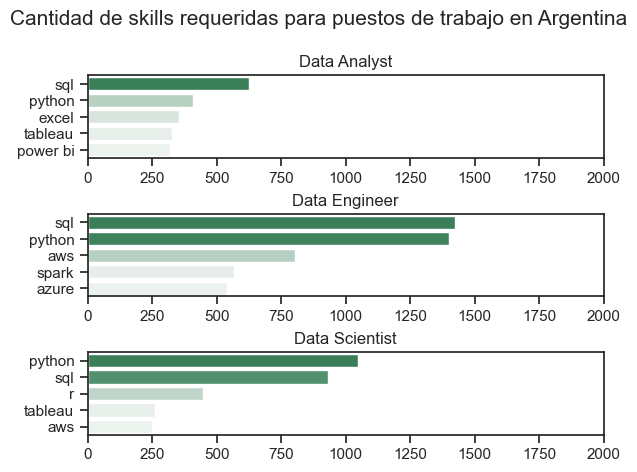

In [ ]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    # [::-1] revierte el orden de las filas para que el gráfico se muestre de arriba hacia abajo (valores más altos arriba)   

    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='light:seagreen')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 2000)

fig.suptitle('Cantidad de skills requeridas para puestos de trabajo en Argentina', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

### Conversión de números a porcentaje

Before we can calculate the percentages, we need the total counts for the jobs posted by job title. 

In [ ]:
# Calculate the frequency of each job title and reset index
df_job_title_count = df_ARG['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,2265
1,Data Scientist,1617
2,Data Analyst,1273
3,Software Engineer,1267
4,Senior Data Engineer,647
5,Business Analyst,453
6,Senior Data Scientist,350
7,Cloud Engineer,322
8,Machine Learning Engineer,287
9,Senior Data Analyst,255


First merge df_skills_count and df_job_title_count, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. 

In [19]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column.

In [20]:
df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,1424,2265,62.869757
1,python,Data Engineer,1401,2265,61.854305
2,python,Data Scientist,1048,1617,64.811379
3,sql,Data Scientist,930,1617,57.513915
4,aws,Data Engineer,803,2265,35.452539
...,...,...,...,...,...
1261,airtable,Machine Learning Engineer,1,287,0.348432
1262,word,Cloud Engineer,1,322,0.310559
1263,airtable,Data Analyst,1,1273,0.078555
1264,zoom,Senior Data Engineer,1,647,0.154560


### Barplot para visualizar las skills según cantidad de apariciones con porcentajes

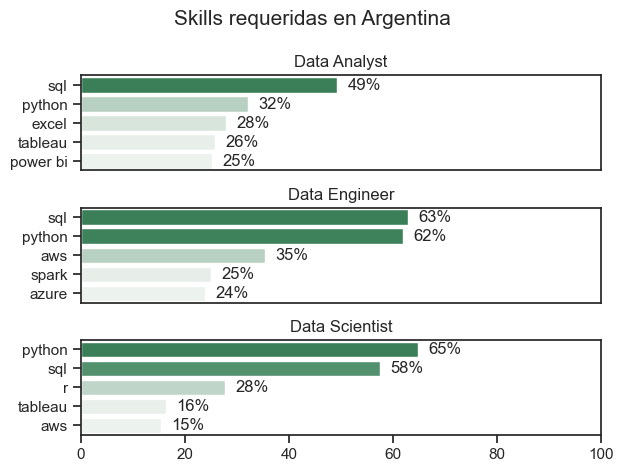

In [ ]:
fig, ax = plt.subplots(len(job_titles), 1)

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='light:seagreen')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 100)
    
    # Remover las escalas de los ejes x excepto para el último gráfico
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # Percentage labels en las barras
    # v sería el eje x, n sería el eje y
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 2, n, f'{v:.0f}%', va='center')
        # v + 2: la distancia del texto al final de la barra
        # v:0.f: formatea el número como porcentaje sin decimales

fig.suptitle('Skills requeridas en Argentina', fontsize=15)
fig.tight_layout(h_pad=1) # Controla el espaciado vertical entre las subplots (filas)
plt.show()